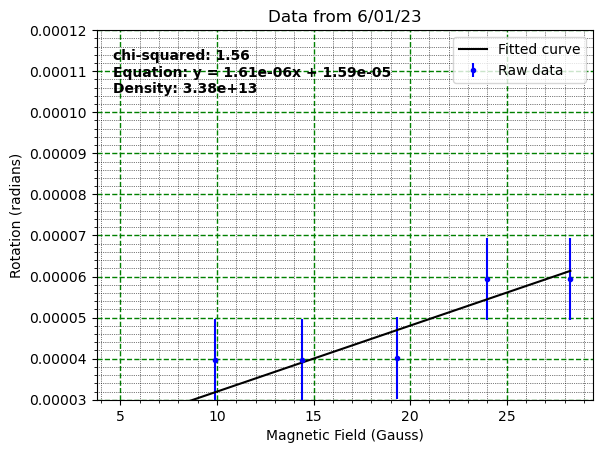

In [24]:


#import all the things!!!

#real python libraries
import numpy as np
#stuff I wrote
import DataSet as ds
import densityplots as den
import Functions as func
import plotSettings as ps
import Utilities as util
import densityCalculations as calc


#let's try to set up a module where I can enter the date collected, and trial number and get back a graph

#step 1 get the data from the json file
#lets try to get the data from 05302023 for this test
filepath = 'Data/rotationdata.json'
target_date = '2023-06-21'
trialnum = 1
my_data = util.get_data_from_file(filepath, target_date, trialnum)

#now I have the data. Excellent. Now it needs to be put into a dataSet object
analysis = ds.DataSet(my_data,func.line,'line',100)

#create a subset of data to analyze
subset = analysis.data_subset_index('after',1)
analysis2 = ds.DataSet(subset, func.line, 'line', 100)

#get the fitted data from the raw subset data
#fitted_data = analysis2.get_fit_line(50, 'line')

#set the plot settings
plot_title = 'Data from 6/01/23'
x_label = 'Magnetic Field (Gauss)'
y_label = 'Rotation (radians)'
vert_min = 3E-5
vert_max =  12E-5


#approximate rubidium density so we can display it on the plot
density_disp_val = analysis2.rb_density_formatted()


my_settings = ps.plotSettings(plot_title, x_label , y_label , vert_min, vert_max, analysis2.plotdata, analysis2.fitted_data, analysis2.chisqd, analysis2.equation, density_disp_val)

#plot the data with the settings specified
#I am currently assuming that there is a +- 0.02 uncertainty in the lockin reading
#I am also assuming that there is an error of +-2E-6 in my calibration
#using these two things and the rules for error propogation when multiplying values
#I come up with error values for these points
den.better_plot(my_settings)


7.80694e-05


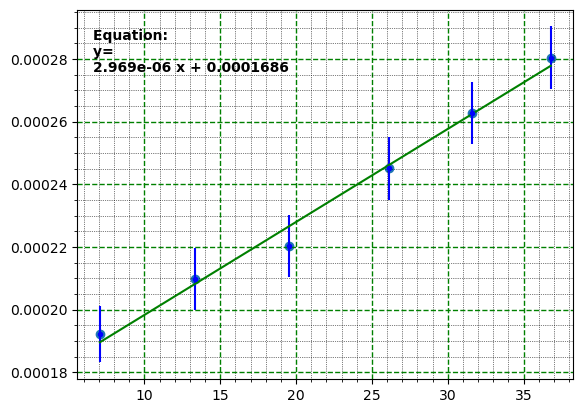

 
2.969e-06 x + 0.0001686
0.5685423433044132


In [31]:
#import all the things!!!
#stuff I wrote
import DataSet as ds
import densityplots as den
import Functions as func
import plotSettings as ps
import Utilities as util
#other python libs
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#let's try to set up a module where I can enter the date collected, and trial number and get back a graph

#step 1 get the data from the json file
#lets try to get the data from 05302023 for this test
filepath = 'Data/rotationdata.json'
target_date = '2023-07-03'
trialnum = 4

my_data = util.get_data_from_file(filepath, target_date, trialnum)

#put the data in a dataframe, a thing I wish I had known about earlier lol
subset = my_data.get_plotable_subset('after',1)

#approximate rubidium density so we can display it on the plot
#density_disp_val = analysis.rb_density_formatted()
df = pd.DataFrame({'x':subset.x , 'y':subset.y, 'y_error':subset.y_error})
print(my_data.laser_wavelength)


#fit polynomial models up to degree 5
model1 = np.poly1d(np.polyfit(df.x, df.y, 1))
#model2 = np.poly1d(np.polyfit(df.x, df.y, 2))
#model3 = np.poly1d(np.polyfit(df.x, df.y, 3))
#model4 = np.poly1d(np.polyfit(df.x, df.y, 4))
#model5 = np.poly1d(np.polyfit(df.x, df.y, 5))

chi_squared = np.sum(((np.polyval(model1, df.x) - df.y)/df.y_error) ** 2)

numpoints = len(df.x)

#create scatterplot
polyline = np.linspace(df.x[0], df.x[numpoints-1], 100)
plt.scatter(df.x, df.y)
plt.errorbar(df.x, df.y,np.abs(df.y_error), fmt='b.', label='Raw data')
plt.minorticks_on()
plt.grid(which= 'major', color = 'green', linestyle = '--', linewidth = '1.0')
plt.grid(which= 'minor', linestyle=':', linewidth='0.5', color='black')

#add fitted polynomial lines to scatterplot 
plt.plot(polyline, model1(polyline), color='green')
#plt.plot(polyline, model2(polyline), color='red')
#plt.plot(polyline, model3(polyline), color='purple')
#plt.plot(polyline, model4(polyline), color='blue')
#plt.plot(polyline, model5(polyline), color='orange')
plt.figtext(0.15, 0.75, 'Equation: \ny='+str(model1), fontweight = "bold")

plt.show()
print(model1)
print(chi_squared)

/Users/eleanor/miniconda3/envs/my_x86_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/eleanor/miniconda3/envs/my_x86_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


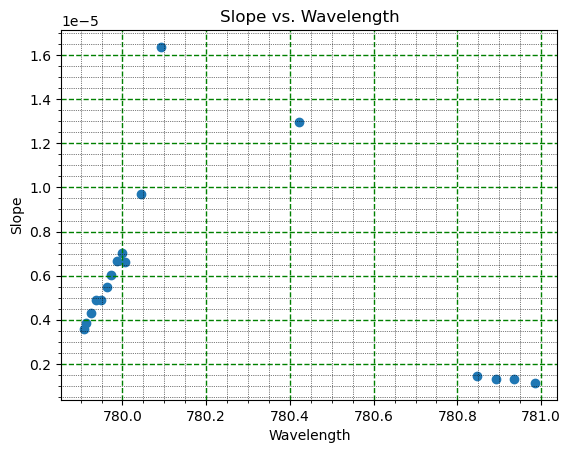

In [12]:
#DATA: 6/20/23, trial 1
#import all the things!!!
import matplotlib.pyplot as plt

#stuff I wrote
import DataSet as ds
import densityplots as den
import Functions as func
import plotSettings as ps
import numpy as np
import Utilities as util

#let's try to set up a module where I can enter the date collected, and trial number and get back a graph

#step 1 get the data from the json file
#lets try to get the data from 05302023 for this test
wavelengths1 = np.array([779.999,779.986,779.973,779.962,779.949,779.936,779.924,779.913,779.908])
slopes1 = np.array([0.000007034,0.000006659,0.000006022,0.000005503,0.000004895,0.000004889,0.000004291,0.000003872,0.000003583])

wavelengths2 = np.array([780.985,780.936,780.891,780.847,780.421,780.093,780.044,780.005])
slopes2 = np.array([0.000001137,0.000001333,0.000001335,0.000001452,0.00001295,0.00001637,0.0000097,0.00000663])

wavelengths = np.concatenate([wavelengths1, wavelengths2])
slopes = np.concatenate([slopes1, slopes2])

df = pd.DataFrame({'x':wavelengths , 'y':slopes})


#fit polynomial models up to degree 5
model1 = np.poly1d(np.polyfit(df.x, df.y, 1))
model2 = np.poly1d(np.polyfit(df.x, df.y, 2))
model3 = np.poly1d(np.polyfit(df.x, df.y, 3))
model4 = np.poly1d(np.polyfit(df.x, df.y, 4))
model5 = np.poly1d(np.polyfit(df.x, df.y, 5))
#model6 = np.poly1d(np.polyfit(np.log(df.x), df.y, 1))

numpoints = len(df.x)

#create scatterplot
polyline = np.linspace(df.x[0], df.x[numpoints-1], 100)
plt.scatter(df.x, df.y)

#add fitted polynomial lines to scatterplot 
#plt.plot(polyline, model1(polyline), color='green')
#plt.plot(polyline, model2(polyline), color='red')
#plt.plot(polyline, model3(polyline), color='purple')
#plt.plot(polyline, model4(polyline), color='blue')
#plt.plot(polyline, model5(polyline), color='orange')
#plt.plot(polyline, model6(polyline), color='orange')


plt.minorticks_on()
plt.grid(which= 'major', color = 'green', linestyle = '--', linewidth = '1.0')
plt.grid(which= 'minor', linestyle=':', linewidth='0.5', color='black')

plt.xlabel("Wavelength")
plt.ylabel("Slope")
plt.title("Slope vs. Wavelength")
plt.show()



/Users/eleanor/miniconda3/envs/my_x86_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/eleanor/miniconda3/envs/my_x86_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


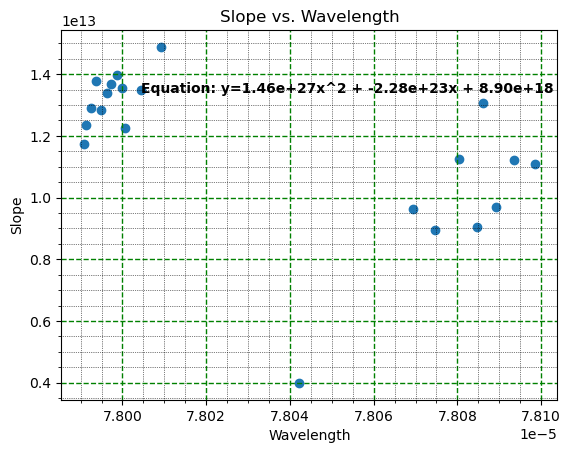

1.46e+27x^2 + -2.28e+23x + 8.90e+18


In [32]:
#DATA: 6/20/23, trial 1
#import all the things!!!
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
#let's try to set up a module where I can enter the date collected, and trial number and get back a graph

#step 1 get the data from the json file
#lets try to get the data from 05302023 for this test

wavelengths2 = np.array([0.0000780985,0.0000780936,0.0000780891,0.000078086,0.0000780847,0.0000780803,0.0000780747,0.0000780694,0.0000780421,0.0000780093,0.0000780044,0.0000780005,0.0000779999,0.0000779986,0.0000779973,0.0000779962,0.0000779949,0.0000779936,0.0000779924,0.0000779913,0.0000779908])
density = np.array([11077212708085.7,11210519575026.5,9706735026170.76,13060808634399.7,9054701080942.73,11244929282902.7,8951938442261.84,9644304696649,3993831877643.81,14881979475495.9,13500802547181.2,12263308567849.9,13546829939394.2,13959935725703.1,13695050375827.9,13373801982698.3,12832173722403.6,13786909466151.3,12914576445121.8,12347988622181.6,11724653808026.7])


df = pd.DataFrame({'x':wavelengths2 , 'y':density})


#fit polynomial models up to degree 5
fit1 = np.polyfit(df.x, df.y, 1)
fit2 = np.polyfit(df.x, df.y, 2)
fit3 = np.polyfit(df.x, df.y, 3)
fit4 = np.polyfit(df.x, df.y, 4)
fit5 = np.polyfit(df.x, df.y, 5)

model1 = np.poly1d(fit1)
model2 = np.poly1d(fit2)
model3 = np.poly1d(fit3)
model4 = np.poly1d(fit4)
model5 = np.poly1d(fit5)

numpoints = len(df.x)

def getEqnString(fit):
    leng = len(fit)
    max_deg = leng-1
    eqn = ""
    for i in fit:
        where = (np.where(fit==i)[0][0])
        if (where<max_deg):
            if(max_deg-where ==1):
                eqn = eqn+str("%.2e" % i)+"x + "
            else:
                eqn = eqn+str("%.2e" % i)+"x"+"^"+str(max_deg-where)+" + "
        if (where==max_deg):
            eqn = eqn+str("%.2e" % i)

    return eqn


#create scatterplot
polyline = np.linspace(df.x[0], df.x[numpoints-1], 100)
plt.scatter(df.x, df.y)

#add fitted polynomial lines to scatterplot 
#plt.plot(polyline, model1(polyline), color='green')
#plt.plot(polyline, model2(polyline), color='red')
#plt.plot(polyline, model3(polyline), color='purple')
#plt.plot(polyline, model4(polyline), color='blue')
#plt.plot(polyline, model5(polyline), color='orange')

plt.minorticks_on()
plt.grid(which= 'major', color = 'green', linestyle = '--', linewidth = '1.0')
plt.grid(which= 'minor', linestyle=':', linewidth='0.5', color='black')
plt.figtext(0.25, 0.75, 'Equation: y='+str(getEqnString(fit2)), fontweight = "bold")


plt.xlabel("Wavelength")
plt.ylabel("Slope")
plt.title("Slope vs. Wavelength")
plt.show()

print(getEqnString(fit2))
